In [246]:
!pip install imblearn

## Importing Libraries

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, figure
import seaborn as sns
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import math
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier
import itertools
from scipy.stats import ttest_ind, wilcoxon, ttest_rel, friedmanchisquare, rankdata
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
import time
import Orange

## Importing Datasets

In [248]:
shoppers_intention=pd.read_csv("input_data/online_shoppers_intention.csv")
heart_disease=pd.read_csv("input_data/heart.csv")
marketing_campaign=pd.read_csv("input_data/marketing_campaign.csv")

## Dividing Dataset and Deducing categorical and numerical columns

In [249]:
x_shopper=shoppers_intention.iloc[:,:-1]; y_shopper=shoppers_intention.iloc[:,-1]
x_heart=heart_disease.iloc[:,:-1]; y_heart=heart_disease.iloc[:,-1]
x_market=marketing_campaign.iloc[:,0:6].join(marketing_campaign.iloc[:,7:]); y_market=marketing_campaign.iloc[:,6]; y_market=(y_market>0).astype(int); x_market['Dt_Customer']=pd.to_datetime(x_market['Dt_Customer'])
n_shopper=x_shopper.select_dtypes(include=['int64','float64']).columns
n_heart=x_heart.select_dtypes(include=['int64','float64']).columns
n_heart=n_heart.drop(['cp','thal','slope'])

## Preprocessing Date Columns and Generating Age column for Market

In [250]:
"""Processing Marketing Data """
x_market['Year_Birth']=pd.to_datetime(x_market['Year_Birth'], format='%Y')
x_market['Customer_Age_Enrol']=(x_market['Dt_Customer']-x_market['Year_Birth'])/np.timedelta64(1,'Y')
n_market=x_market.select_dtypes(include=['int64','float64']).columns

## Checking data Imbalance

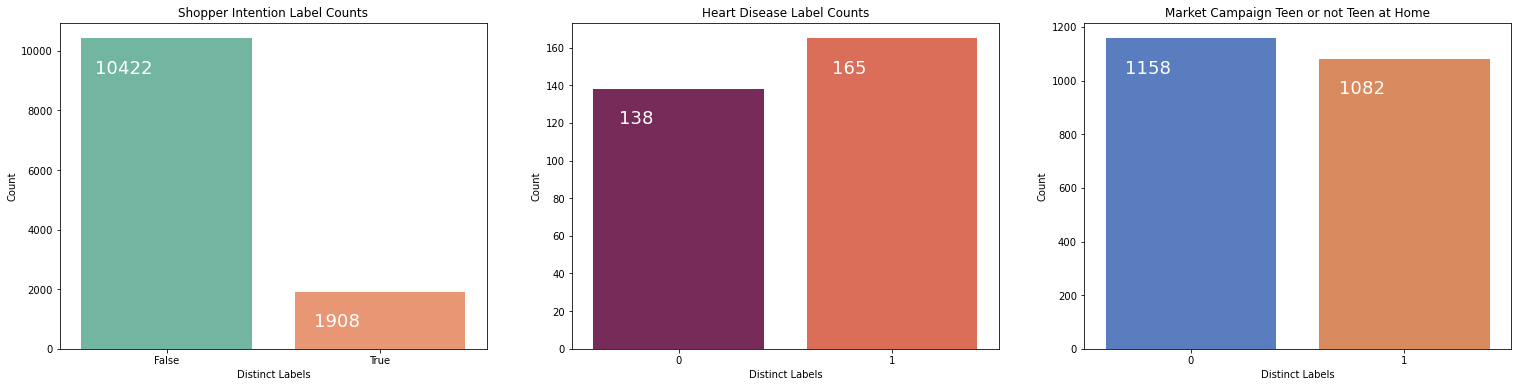

In [251]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(26,6))
sns.countplot(y_shopper, palette = 'Set2', ax=ax[0])
ax[0].set_title('Shopper Intention Label Counts'); ax[0].set_xlabel('Distinct Labels'); ax[0].set_ylabel('Count')
sns.countplot(y_heart, palette = 'rocket', ax=ax[1])
ax[1].set_title('Heart Disease Label Counts'); ax[1].set_xlabel('Distinct Labels'); ax[1].set_ylabel('Count')
sns.countplot(y_market, palette = 'muted', ax=ax[2])
ax[2].set_title('Market Campaign Teen or not Teen at Home'); ax[2].set_xlabel('Distinct Labels'); ax[2].set_ylabel('Count')

for i in range(3):
    for p in ax[i].patches:
        ax[i].annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)

## Checking correlation for datasets

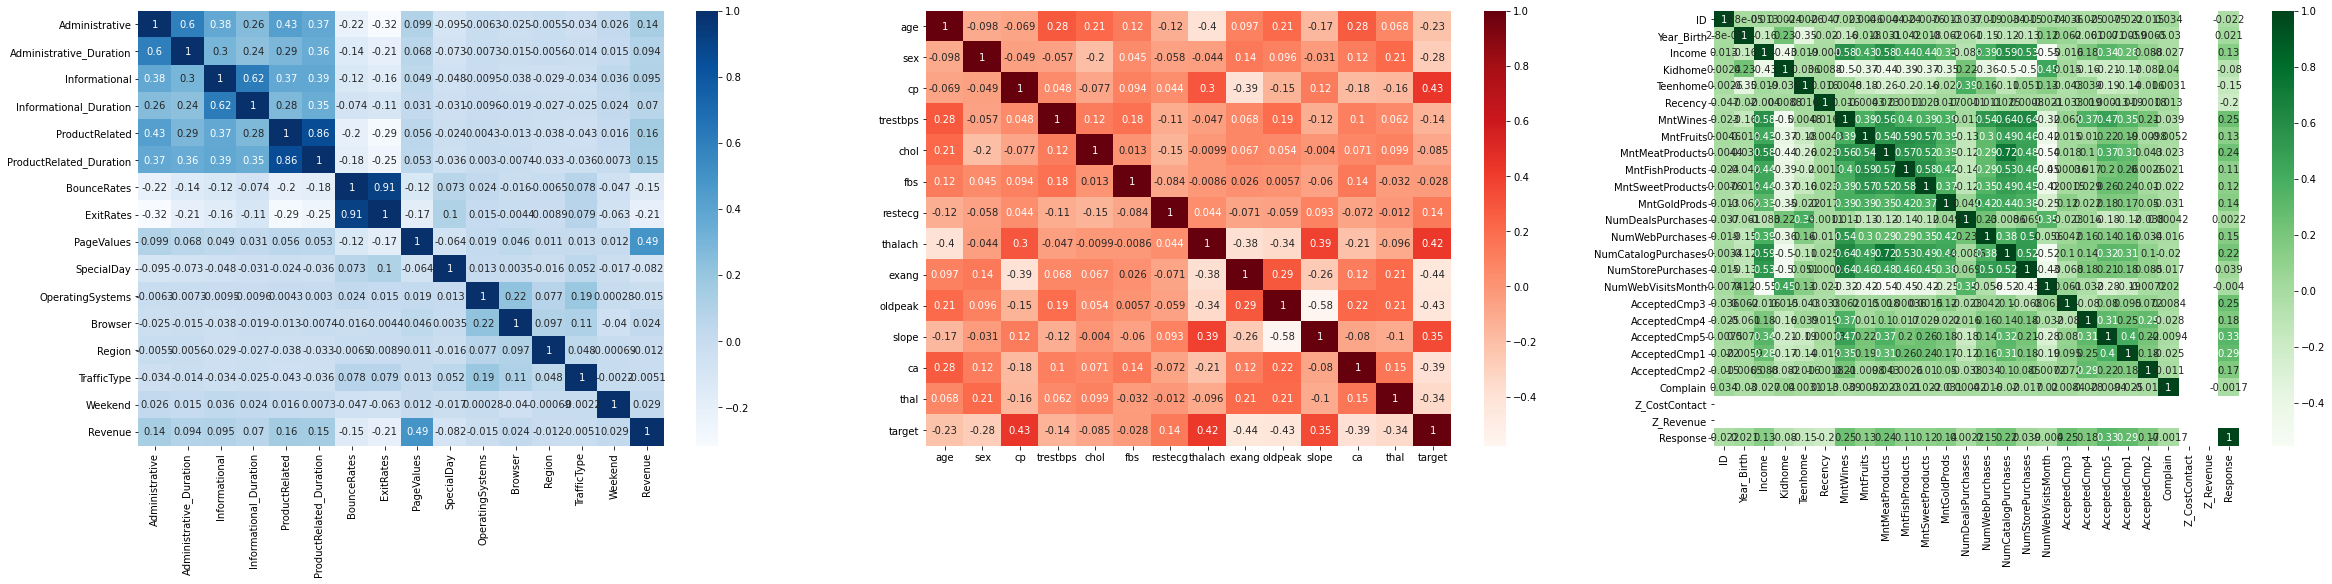

In [252]:
corr_shopper=shoppers_intention.corr()
corr_heart=heart_disease.corr()
corr_marketing=marketing_campaign.corr()
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(40,8))        
sns.heatmap(corr_shopper, annot=True, cmap=plt.cm.Blues, ax=ax[0])
sns.heatmap(corr_heart, annot=True, cmap=plt.cm.Reds, ax=ax[1])
sns.heatmap(corr_marketing, annot=True, cmap=plt.cm.Greens, ax=ax[2])
drop_shopper=['BounceRates','ProductRelated','Administrative_Duration','Informational']
shoppers_intention=shoppers_intention.drop(columns=drop_shopper)

## Imputing Dataset for Nan and Infinite data

In [253]:
"""Imputing Missing Data Marketing Campaign"""
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(x_market[n_market])
x_market[n_market] = imputer.transform(x_market[n_market])

## Encoding Numerical column in Dataset 

In [254]:
"""Encoding Numeric Data for 3 datasets"""
scalar=MinMaxScaler()
x_shopper[n_shopper]=scalar.fit_transform(x_shopper[n_shopper])
x_heart[n_heart]=scalar.fit_transform(x_heart[n_heart])
x_market[n_market]=scalar.fit_transform(x_market[n_market])

## Encoding Categorical columns in dataset

In [255]:
"""Encoding Categorical Data for Shopper Intention Data"""

"""Encoding visitor type OHE"""
visitor_type=pd.get_dummies(x_shopper['VisitorType'])
x_shopper=x_shopper.drop('VisitorType', axis=1)
x_shopper=x_shopper.join(visitor_type)

"""Encoding weekend and Revenue Label Encoder"""
label_encoder=LabelEncoder()
x_shopper['Weekend']=label_encoder.fit_transform(x_shopper['Weekend'])
y_shopper=pd.DataFrame(label_encoder.fit_transform(y_shopper))

"""Encoding Month"""
month=pd.DataFrame(shoppers_intention['Month'])
ct=ColumnTransformer(transformers=[('encoder',OrdinalEncoder(),[0])], remainder='passthrough')
ordinal_encode=ct.fit_transform(month)
x_shopper['Month']=ordinal_encode

In [256]:
"""Encoding Categorical Data for Heart Disease Data"""

x_heart.cp = x_heart.cp.map({0:"asymptomatic", 1: "typical angina", 2:"atypical angina", 3:"non-anginal pain"})
x_heart.slope =x_heart.slope.map({1:"upsloping", 2:"flat", 3:"downsloping"})
x_heart.thal = x_heart.thal.map({1:"normal",2:"fixed defect", 3:"reversable defect"})

"""Encoding cp, slope and thal"""
x_heart=pd.get_dummies(x_heart,drop_first=True)

In [257]:
"""Encoding Categorical Data for Market Campaign Intention Data"""

"""Encoding Education and Marital type OHE"""
Education=pd.get_dummies(x_market['Education'])
x_market=x_market.drop('Education', axis=1)
x_market=x_market.join(Education)

Marital=pd.get_dummies(x_market['Marital_Status'])
x_market=x_market.drop('Marital_Status', axis=1)
x_market=x_market.join(Marital)

# """Encoding weekend and Revenue Label Encoder"""
# label_encoder=LabelEncoder()
# x_market['Marital_Status']=label_encoder.fit_transform(x_market['Marital_Status'])

In [258]:
x_market=x_market.drop(['Year_Birth','Dt_Customer'],axis=1)

## Checking Feature Importance

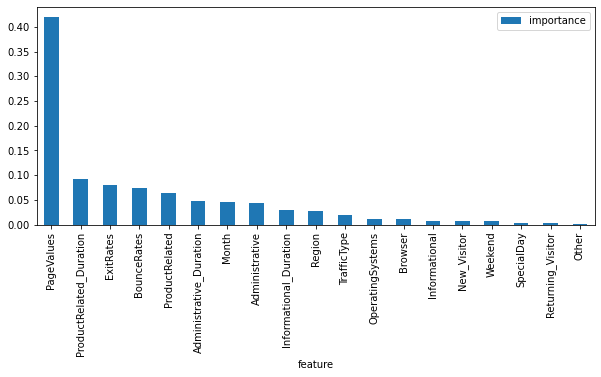

In [259]:
dt_shopper = DecisionTreeClassifier();
dt_shopper.fit(x_shopper, y_shopper);
# extract important features
score = np.round(dt_shopper.feature_importances_,3)
importances = pd.DataFrame({'feature':x_shopper.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (10, 4)
importances.plot.bar();

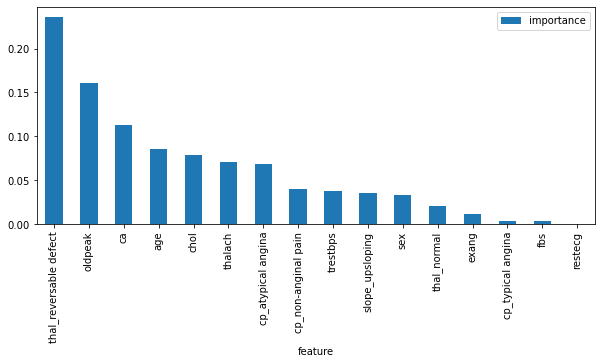

In [260]:
dt_heart = DecisionTreeClassifier();
dt_heart.fit(x_heart, y_heart);
# extract important features
score = np.round(dt_heart.feature_importances_,3)
importances = pd.DataFrame({'feature':x_heart.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (10, 4)
importances.plot.bar();

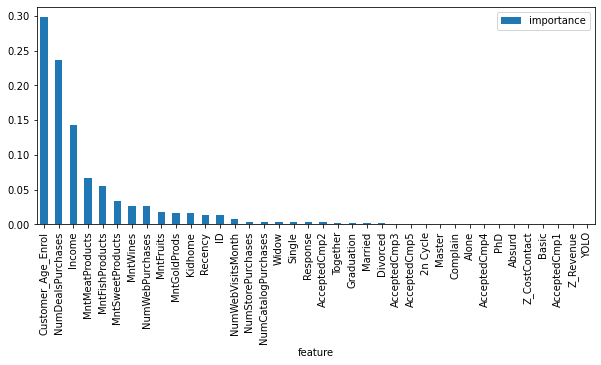

In [261]:
dt_market = DecisionTreeClassifier();
dt_market.fit(x_market, y_market);
# extract important features
score = np.round(dt_market.feature_importances_,3)
importances = pd.DataFrame({'feature':x_market.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (10, 4)
importances.plot.bar(); 

## Performing Feature Selection using RFE

In [262]:
"""Feature Selection Shopper Data"""
rfe_shopper=RFE(dt_shopper,n_features_to_select=5)
rfe_shopper.fit(x_shopper, y_shopper)
x_shopper=x_shopper[x_shopper.columns[rfe_shopper.support_]]

"""Feature Selection Heart Data"""
rfe_heart=RFE(dt_heart,n_features_to_select=7)
rfe_heart.fit(x_heart, y_heart)
x_heart=x_heart[x_heart.columns[rfe_heart.support_]]

"""Feature Selection Market Data"""
rfe_market=RFE(dt_market,n_features_to_select=10)
rfe_market.fit(x_market, y_market)
x_market=x_market[x_market.columns[rfe_market.support_]]

## Function to generate Unlabelled Data

In [263]:
def create_unlabelled_data(X,Y, label_ratio):
    gen_index=int(X.shape[0]*(1-label_ratio))
    x_label=X.iloc[:gen_index,:]; y_label=Y.iloc[:gen_index]
    x_ul=X.iloc[gen_index+1:,:]; y_ul=Y.iloc[gen_index+1:]
    return x_label,y_label, x_ul, y_ul 

## Creating Self Training Semi Supervised Learning Algorithm

In [264]:
def training_semi_supervised(dataset, label_ratio, balanced_flag=False):
    x_train, x_test, y_train, y_test=train_test_split(dataset.iloc[:,:-1],dataset.iloc[:,-1],train_size=0.7, random_state=999, stratify=dataset.iloc[:,-1])
    
    if balanced_flag:
        #Balance the data
        x_train_s,y_train_s=SMOTE(sampling_strategy='minority').fit_resample(x_train, y_train)
        x_label, y_label, x_ul, y_ul=create_unlabelled_data(x_train_s, y_train_s, label_ratio)

    else:
        x_label, y_label, x_ul, y_ul=create_unlabelled_data(x_train, y_train, label_ratio)
    rf_ssl=RandomForestClassifier(n_estimators=5,n_jobs=16, criterion='entropy')
    rf_ssl.fit(x_train,y_train)
    high_confidence=[1]
    start_time=time.time()
    while len(high_confidence)>0 and label_ratio!=0:
        rf_ssl=RandomForestClassifier(n_estimators=25,n_jobs=16)
        rf_ssl.fit(x_label,y_label)
        df_inter_pred=pd.DataFrame([])
        predict_probs=rf_ssl.predict_proba(x_ul)
        df_inter_pred['pred_0']=predict_probs[:,0]
        df_inter_pred['pred_1']=predict_probs[:,1]
        df_inter_pred['preds']=rf_ssl.predict(x_ul)
        df_inter_pred.index = x_ul.index
        high_confidence=pd.concat([df_inter_pred.loc[df_inter_pred['pred_0'] > 0.99], df_inter_pred.loc[df_inter_pred['pred_1'] > 0.99]], axis=0)
        x_label = pd.concat([x_label, x_ul.loc[high_confidence.index]], axis=0)
        y_label = pd.concat([y_label, high_confidence.preds])
        x_ul = x_ul.drop(index=high_confidence.index,axis=0)
    elapsed_time=time.time()-start_time
    y_pred_f=rf_ssl.predict(x_test)
    y_pred_prob_f=rf_ssl.predict_proba(x_test)[:,1]
    return metrics.f1_score(y_test,y_pred_f), y_test, y_pred_prob_f, elapsed_time



## Creating Ensemble based Semi Supervised Learning Algorithm

In [265]:
def training_semi_supervised_ensemble(dataset, label_ratio, balanced_flag=False):
    x_train, x_test, y_train, y_test=train_test_split(dataset.iloc[:,:-1],dataset.iloc[:,-1],train_size=0.7, random_state=999, stratify=dataset.iloc[:,-1])
    
    if balanced_flag:
        #Balance the data
        x_train_s,y_train_s=SMOTE(sampling_strategy='minority').fit_resample(x_train, y_train)
        x_label, y_label, x_ul, y_ul=create_unlabelled_data(x_train_s, y_train_s, label_ratio)

    else:
        x_label, y_label, x_ul, y_ul=create_unlabelled_data(x_train, y_train, label_ratio)
    start_time=time.time()
    ssl=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',tree_method='gpu_hist',max_depth=5, gamma=0.5)
    ssl.fit(x_label,y_label)
    ssl.save_model('xgb')
    high_confidence=[1]
    while len(high_confidence)>0 and x_ul.shape[0]>0 and label_ratio!=0:
        df_inter_pred=pd.DataFrame([])
        predict_probs=ssl.predict_proba(x_ul)
        df_inter_pred['pred_0']=predict_probs[:,0]
        df_inter_pred['pred_1']=predict_probs[:,1]
        df_inter_pred['preds']=ssl.predict(x_ul)
        df_inter_pred.index = x_ul.index
        high_confidence=pd.concat([df_inter_pred.loc[df_inter_pred['pred_0'] > 0.99], df_inter_pred.loc[df_inter_pred['pred_1'] > 0.99]], axis=0)
        x_label = pd.concat([x_label, x_ul.loc[high_confidence.index]], axis=0)
        y_label = pd.concat([y_label, high_confidence.preds])      
        ssl.fit(x_label,y_label,xgb_model='xgb')
        x_ul = x_ul.drop(index=high_confidence.index,axis=0)
    elapsed_time=time.time()-start_time
    y_pred_f=ssl.predict(x_test)
    y_pred_prob_f=ssl.predict_proba(x_test)[:,1]
    os.remove('xgb')
    return metrics.f1_score(y_test,y_pred_f), y_test, y_pred_prob_f, elapsed_time



## Creating Intrinsic Semi Supervised Learning Algorithm

In [301]:
def training_semi_supervised_intrinsic(dataset, label_ratio, balanced_flag=False):
    x_train, x_test, y_train, y_test=train_test_split(dataset.iloc[:,:-1],dataset.iloc[:,-1],train_size=0.7, random_state=999, stratify=dataset.iloc[:,-1])
    
    if balanced_flag:
        #Balance the data
        x_train_s,y_train_s=SMOTE(sampling_strategy='minority').fit_resample(x_train, y_train)
        x_label, y_label, x_ul, y_ul=create_unlabelled_data(x_train_s, y_train_s, label_ratio)

    else:
        x_label, y_label, x_ul, y_ul=create_unlabelled_data(x_train, y_train, label_ratio)
    start_time=time.time()
    x_train_mixed = np.concatenate((x_label, x_ul)) 
    nolabel = [-1 for _ in range(len(y_ul))]  
    y_train_mixed = np.concatenate((y_label, nolabel))
    ssl_int=LabelSpreading(kernel='knn',n_neighbors=5, alpha=0.5, n_jobs=16,max_iter=250)
    ssl_int.fit(x_train_mixed, y_train_mixed,)
    elapsed_time=time.time()-start_time
    y_pred_f=ssl_int.predict(x_test)
    y_pred_prob_f=ssl_int.predict_proba(x_test)[:,1]
    return metrics.f1_score(y_test,y_pred_f), y_test, y_pred_prob_f, elapsed_time


## Creating Unsupervised Pretraining Learning Algorithm

In [267]:
def training_semi_unsupervised(dataset, label_ratio, balanced_flag=False):
    x_train, x_test, y_train, y_test=train_test_split(dataset.iloc[:,:-1],dataset.iloc[:,-1],train_size=0.7, random_state=999, stratify=dataset.iloc[:,-1])
    balanced_flag=True
    label_ratio=0.5
    if balanced_flag:
        #Balance the data
        x_train_s,y_train_s=SMOTE(sampling_strategy='not majority').fit_resample(x_train, y_train)
        x_label, y_label, x_ul, y_ul=create_unlabelled_data(x_train_s, y_train_s, label_ratio)

    else:
        x_label, y_label, x_ul, y_ul=create_unlabelled_data(x_train, y_train, label_ratio)
    start_time=time.time()
    if label_ratio!=0:
        x_train_mixed = pd.concat([x_label, x_ul],axis=0) 
        #clustering=DBSCAN(eps=0.009,n_jobs=16, metric='euclidean')
        clustering=KMeans(n_clusters=2, n_init=15,algorithm='full')
        clustering.fit(x_train_mixed)
        x_train_mixed['cluster_labels']=clustering.labels_
        
        model=RandomForestClassifier()
        model.fit(x_train_mixed.loc[x_label.index],y_label)
        y_ul_pred=pd.DataFrame(model.predict(x_train_mixed.loc[x_ul.index]))
        y_train_mixed=pd.concat([y_label,y_ul_pred],axis=0)
        fin_model=RandomForestClassifier()
        fin_model.fit(x_train_mixed.iloc[:,:-1],y_train_mixed)
    elapsed_time=time.time()-start_time
    y_pred_f=fin_model.predict(x_test)
    y_pred_prob_f=fin_model.predict_proba(x_test)[:,1]
    return metrics.f1_score(y_test,y_pred_f), y_test, y_pred_prob_f, elapsed_time



## Initializing the dataset and variables

In [268]:
shopper_scaled_data=pd.concat([x_shopper,y_shopper],axis=1)
heart_scaled=pd.concat([x_heart,y_heart],axis=1)
marketing_campaign_scaled=pd.concat([x_market,y_market],axis=1)
label_ratios=[0,0.1,0.2,0.5,0.9,0.95]
np.random.seed(0)

## Function to evaluate F1, Response Time and ROC/AUC

In [269]:
def performance_evaluator_f1(dataset, balanced, label_ratio):
    result_df=pd.DataFrame([])
    inter_df=pd.DataFrame([])
    fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(40,15))
    algorithm=['Self Training', 'Ensemble', 'Unsupervised Pretraining']
    j=0
    k=0
    for i in range(len(label_ratio)):
        inter_df['Label_ratio']=[label_ratio[i]]*3
        inter_df['Algorithm']=algorithm
        f1_self, y_test_self, y_pred_proba_self, elapsed_time_self=training_semi_supervised(dataset,label_ratio[i],balanced)
        f1_ens, y_test_ens, y_pred_proba_ens, elapsed_time_ens=training_semi_supervised_ensemble(dataset,label_ratio[i],balanced)
        f1_uns, y_test_uns, y_pred_proba_uns, elapsed_time_uns=training_semi_unsupervised(dataset,label_ratio[i],balanced)
      #  f1_int, y_test_int, y_pred_proba_int, elapsed_time_int=training_semi_supervised_intrinsic(dataset,label_ratio[i],balanced)
        inter_df['F1 Score']=[f1_self,f1_ens, f1_uns]
        inter_df['Time Consumed(sec)']=[elapsed_time_self, elapsed_time_ens, elapsed_time_uns] 
        result_df=pd.concat([result_df,inter_df])   
        fpr_self,tpr_self, _=metrics.roc_curve(y_test_self, y_pred_proba_self); auc_self=metrics.roc_auc_score(y_test_self, y_pred_proba_self)
        fpr_ens,tpr_ens, _=metrics.roc_curve(y_test_ens, y_pred_proba_ens);auc_ens=metrics.roc_auc_score(y_test_ens, y_pred_proba_ens)
        fpr_uns,tpr_uns, _=metrics.roc_curve(y_test_uns, y_pred_proba_uns);auc_uns=metrics.roc_auc_score(y_test_uns, y_pred_proba_uns)
       # fpr_int,tpr_int, _=metrics.roc_curve(y_test_int, y_pred_proba_int)
        #auc_int=metrics.roc_auc_score(y_test_int, y_pred_proba_int)
        
        ax[j][k].set_title("ROC Plot with %d percent missing values" %(label_ratio[i]*100))
        ax[j][k].plot(fpr_self, tpr_self, 'b', label = 'Self Trained SSL %0.4f' % auc_self)
        ax[j][k].plot(fpr_ens, tpr_ens, 'r', label = 'Ensemble SSL = %0.4f' % auc_ens)
        ax[j][k].plot(fpr_uns, tpr_uns, 'g', label = 'Unsuperived Pretrained SSL AUC = %0.4f' % auc_uns)
        #ax[j][i].plot(fpr_int, tpr_int, 'k', label = 'Intrinsic SSL = %0.4f' % auc_int)
        ax[j][k].set_xlabel("False Positive Ratio")
        ax[j][k].set_ylabel("True Positive Ratio")
        ax[j][k].legend(loc = 'lower right')
        k=k+1
        if i>=2 and j<1:
            j=j+1
            k=0

    return result_df

## Extracting Results for 3 Datasets (Unbalanced Data)

<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fin_model.fit(x_train_mixed.iloc[:,:-1],y_train_mixed)
<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fin_model.fit(x_train_mixed.iloc[:,:-1],y_train_mixed)
<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fin_model.fit(x_train_mixed.iloc[:,:-1],y_train_mixed)
<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fin_model.fit(x_train_mixed.iloc[:,:-1],y_train_mixed)
<ipy

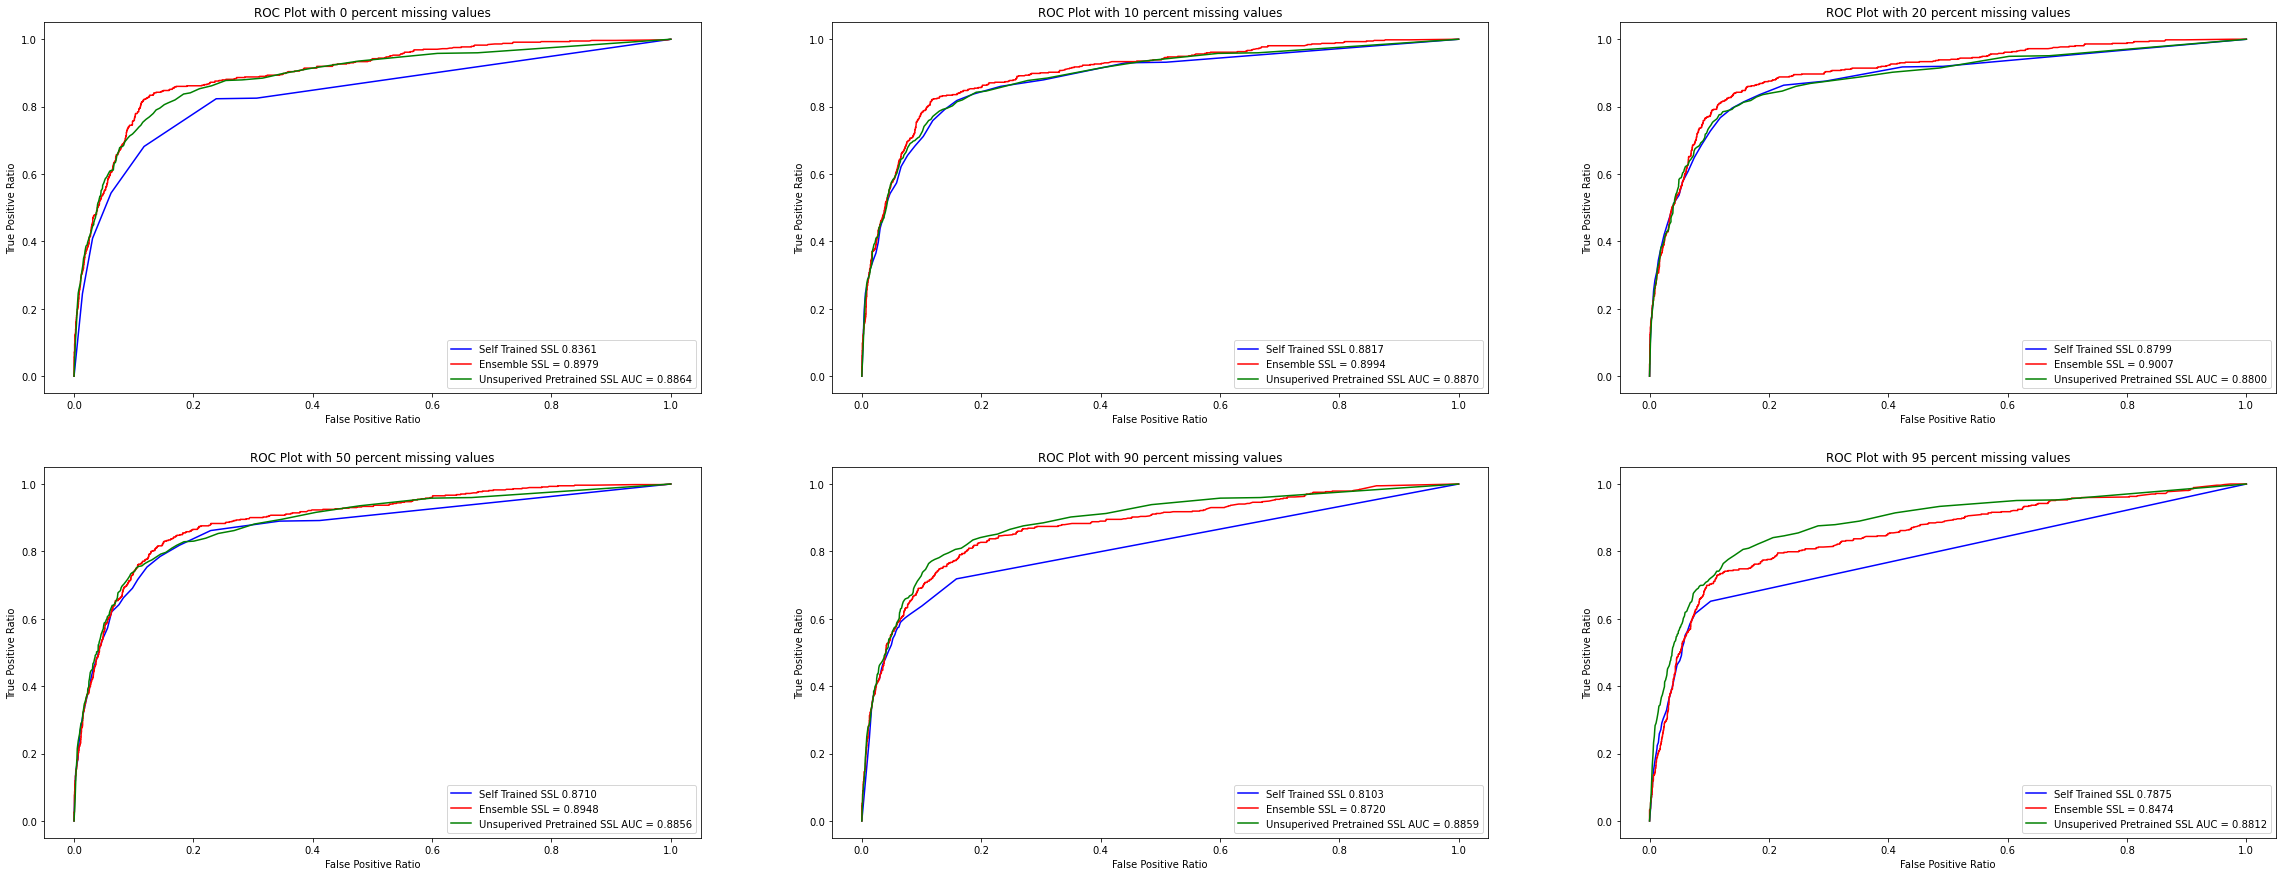

In [270]:
result_df_shopper_unbal=performance_evaluator_f1(shopper_scaled_data,False,label_ratios)

C:\Users\aadit\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fin_model.fit(x_train_mixed.iloc[:,:-1],y_train_mixed)
C:\Users\aadit\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example 

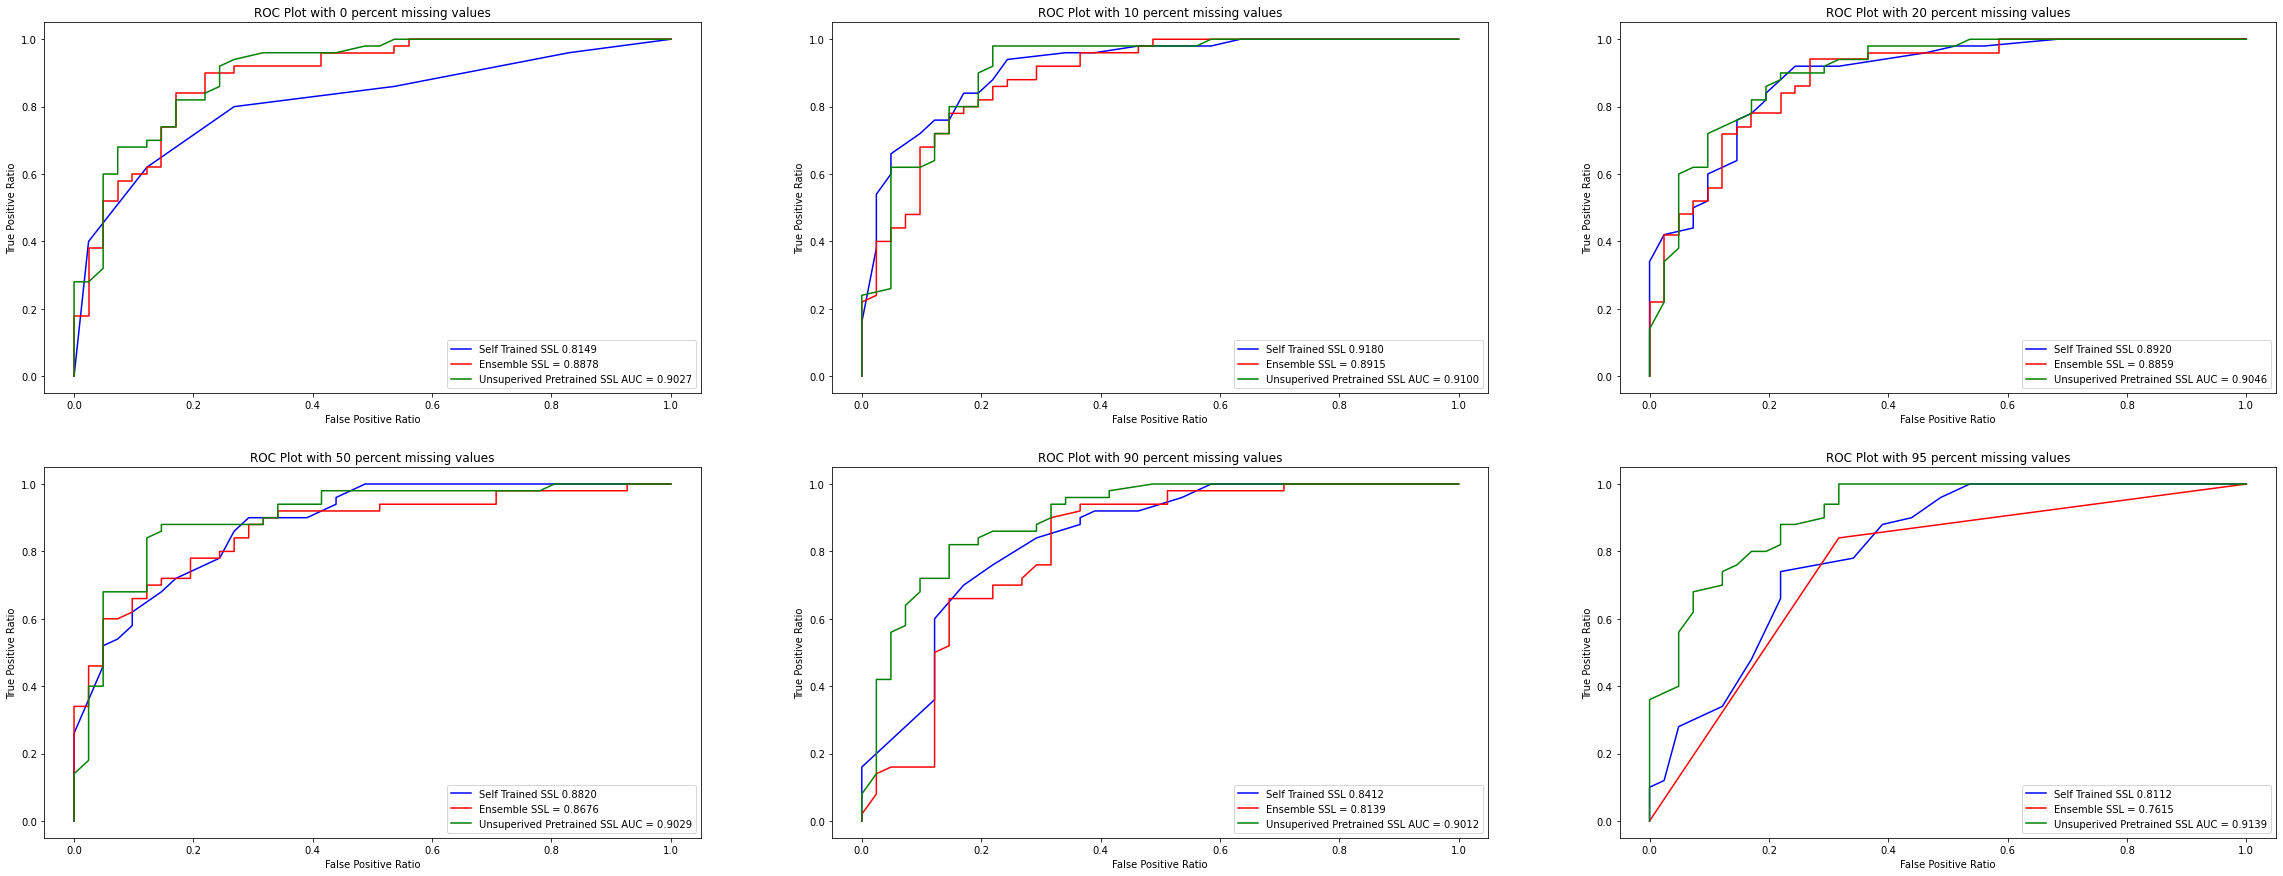

In [271]:
result_df_heart_unbal=performance_evaluator_f1(heart_scaled,False,label_ratios)

C:\Users\aadit\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fin_model.fit(x_train_mixed.iloc[:,:-1],y_train_mixed)
C:\Users\aadit\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example 

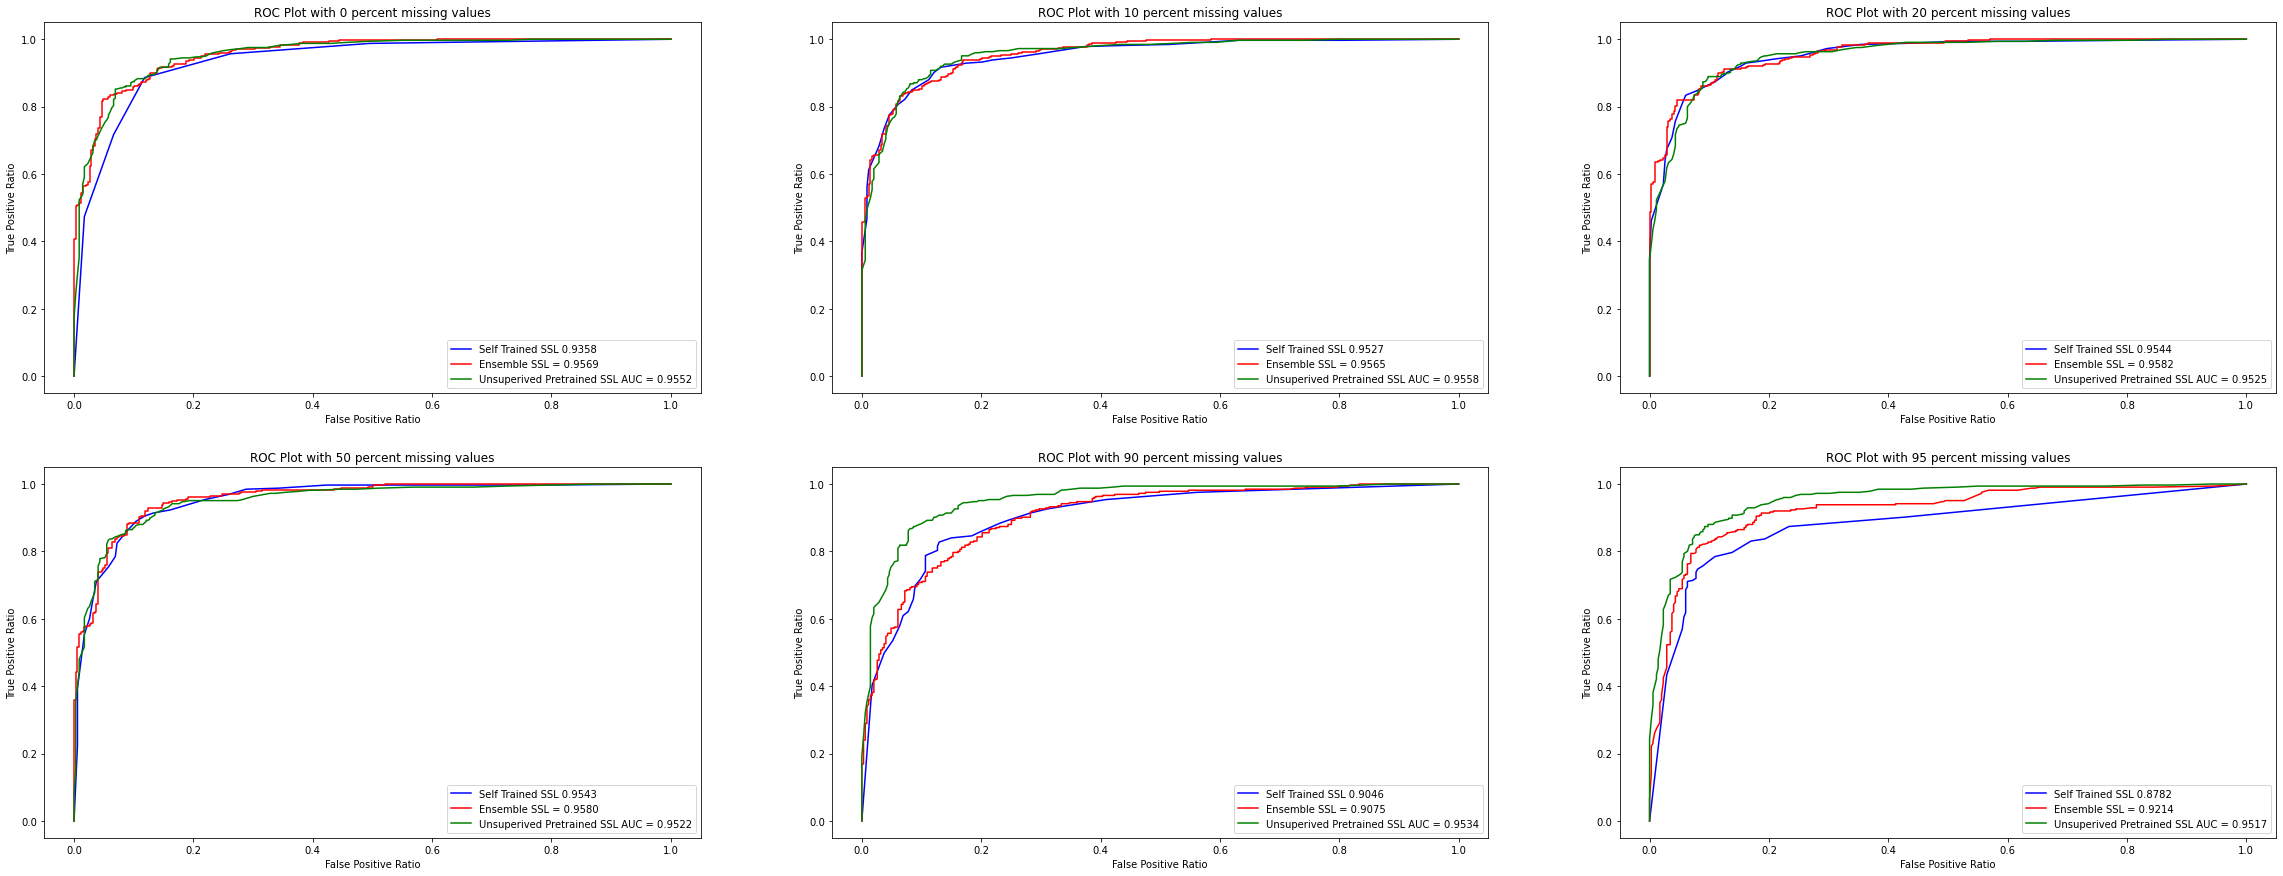

In [272]:
result_df_market_unbal=performance_evaluator_f1(marketing_campaign_scaled,False,label_ratios)

In [289]:
with pd.ExcelWriter('Unbalanced_data.xlsx') as writer:  
    result_df_shopper_unbal.to_excel(writer, sheet_name='Shopper')
    result_df_heart_unbal.to_excel(writer, sheet_name='Heart')
    result_df_market_unbal.to_excel(writer, sheet_name='Market')

## Extracting Results for 3 Datasets (Balanced Dataset)

<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fin_model.fit(x_train_mixed.iloc[:,:-1],y_train_mixed)
<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fin_model.fit(x_train_mixed.iloc[:,:-1],y_train_mixed)
<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fin_model.fit(x_train_mixed.iloc[:,:-1],y_train_mixed)
<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fin_model.fit(x_train_mixed.iloc[:,:-1],y_train_mixed)
<ipy

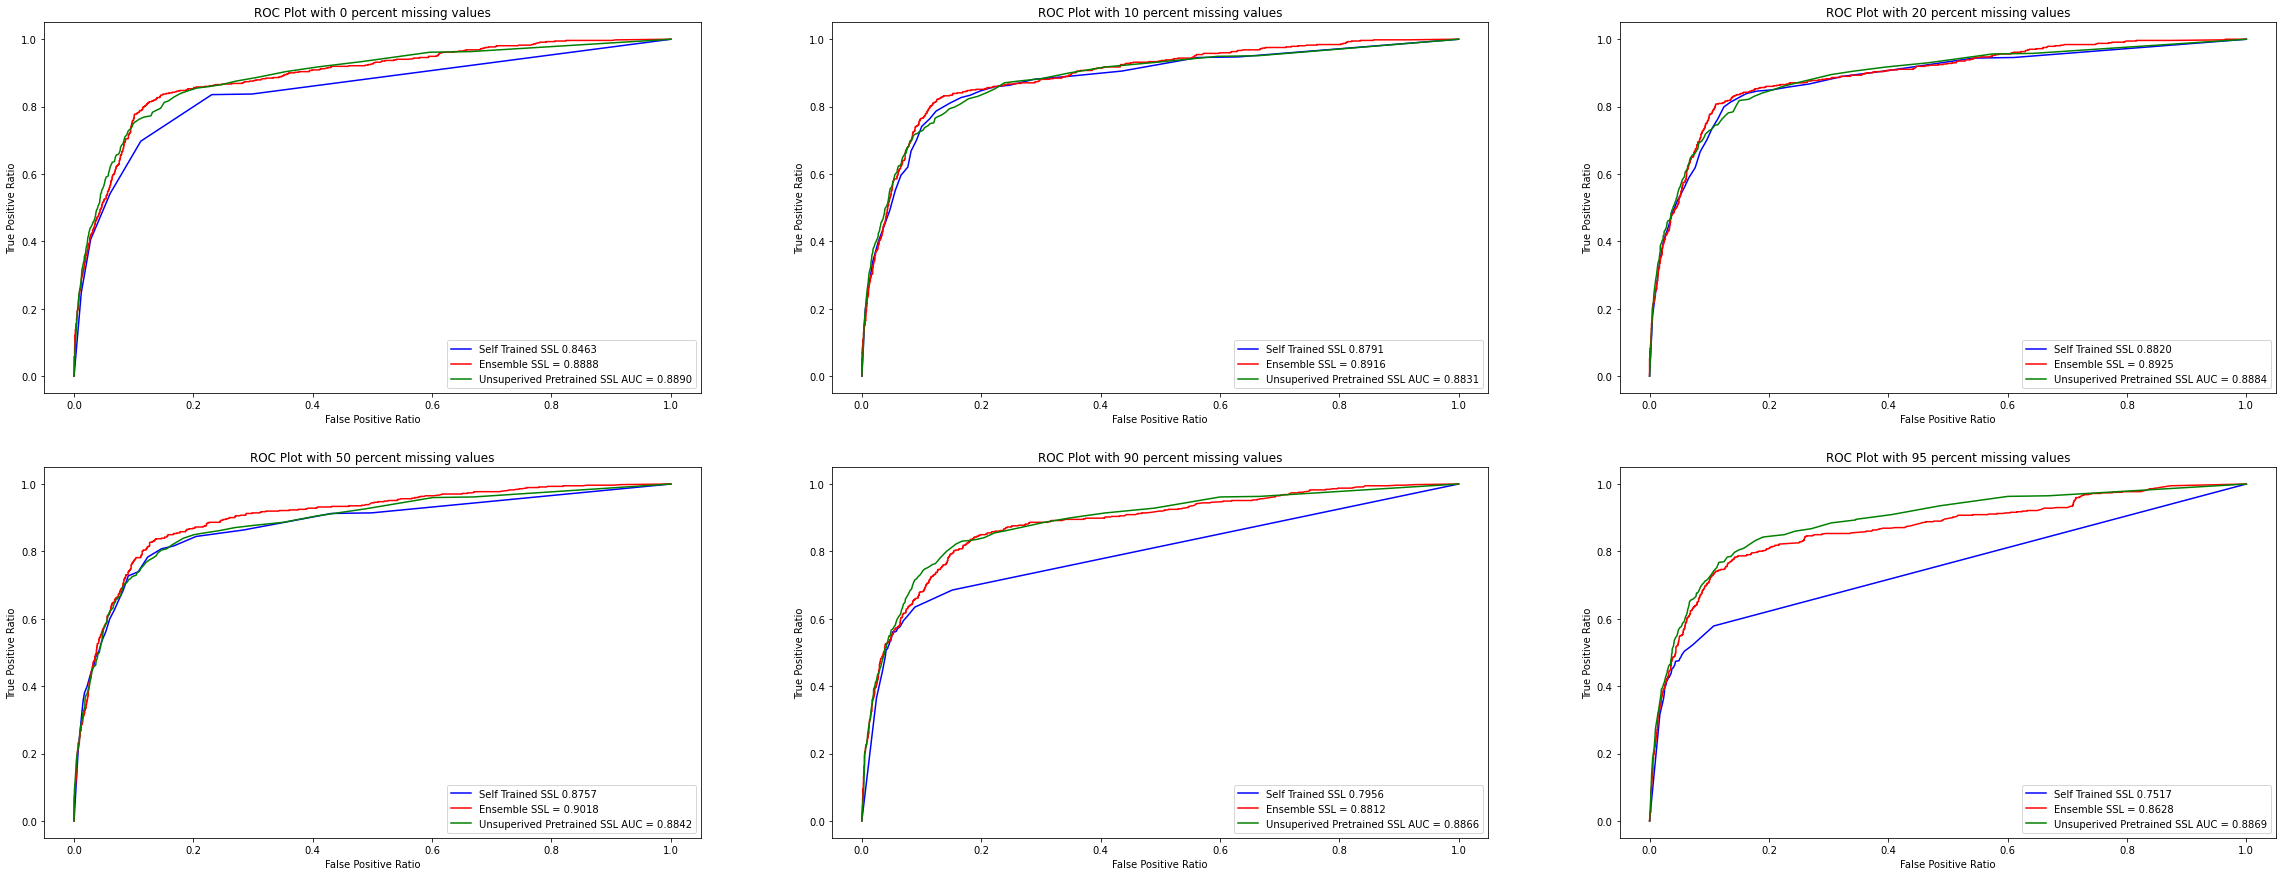

In [274]:
result_df_shopper_bal=performance_evaluator_f1(shopper_scaled_data,True,label_ratios)


C:\Users\aadit\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fin_model.fit(x_train_mixed.iloc[:,:-1],y_train_mixed)
C:\Users\aadit\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example 

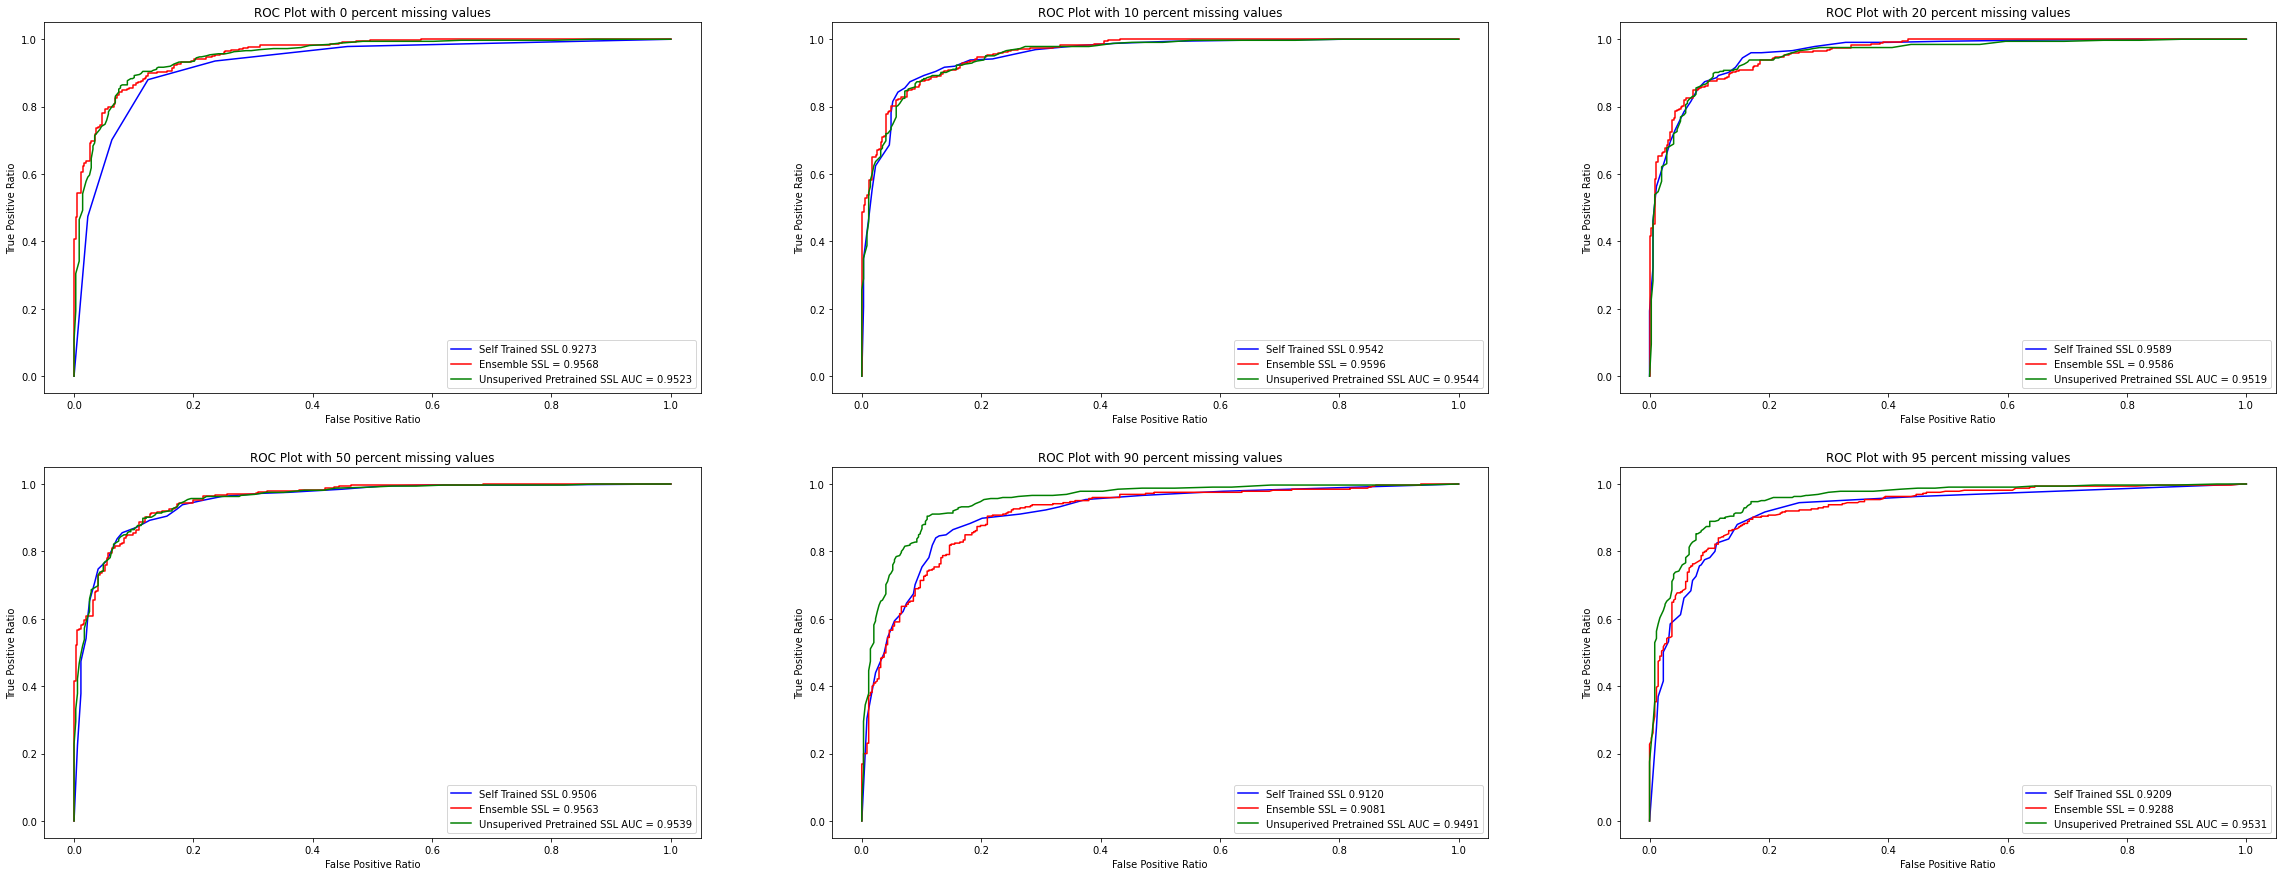

In [275]:
result_df_market_bal=performance_evaluator_f1(marketing_campaign_scaled,True,label_ratios)

C:\Users\aadit\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fin_model.fit(x_train_mixed.iloc[:,:-1],y_train_mixed)
C:\Users\aadit\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-267-5c25967ff665>:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example 

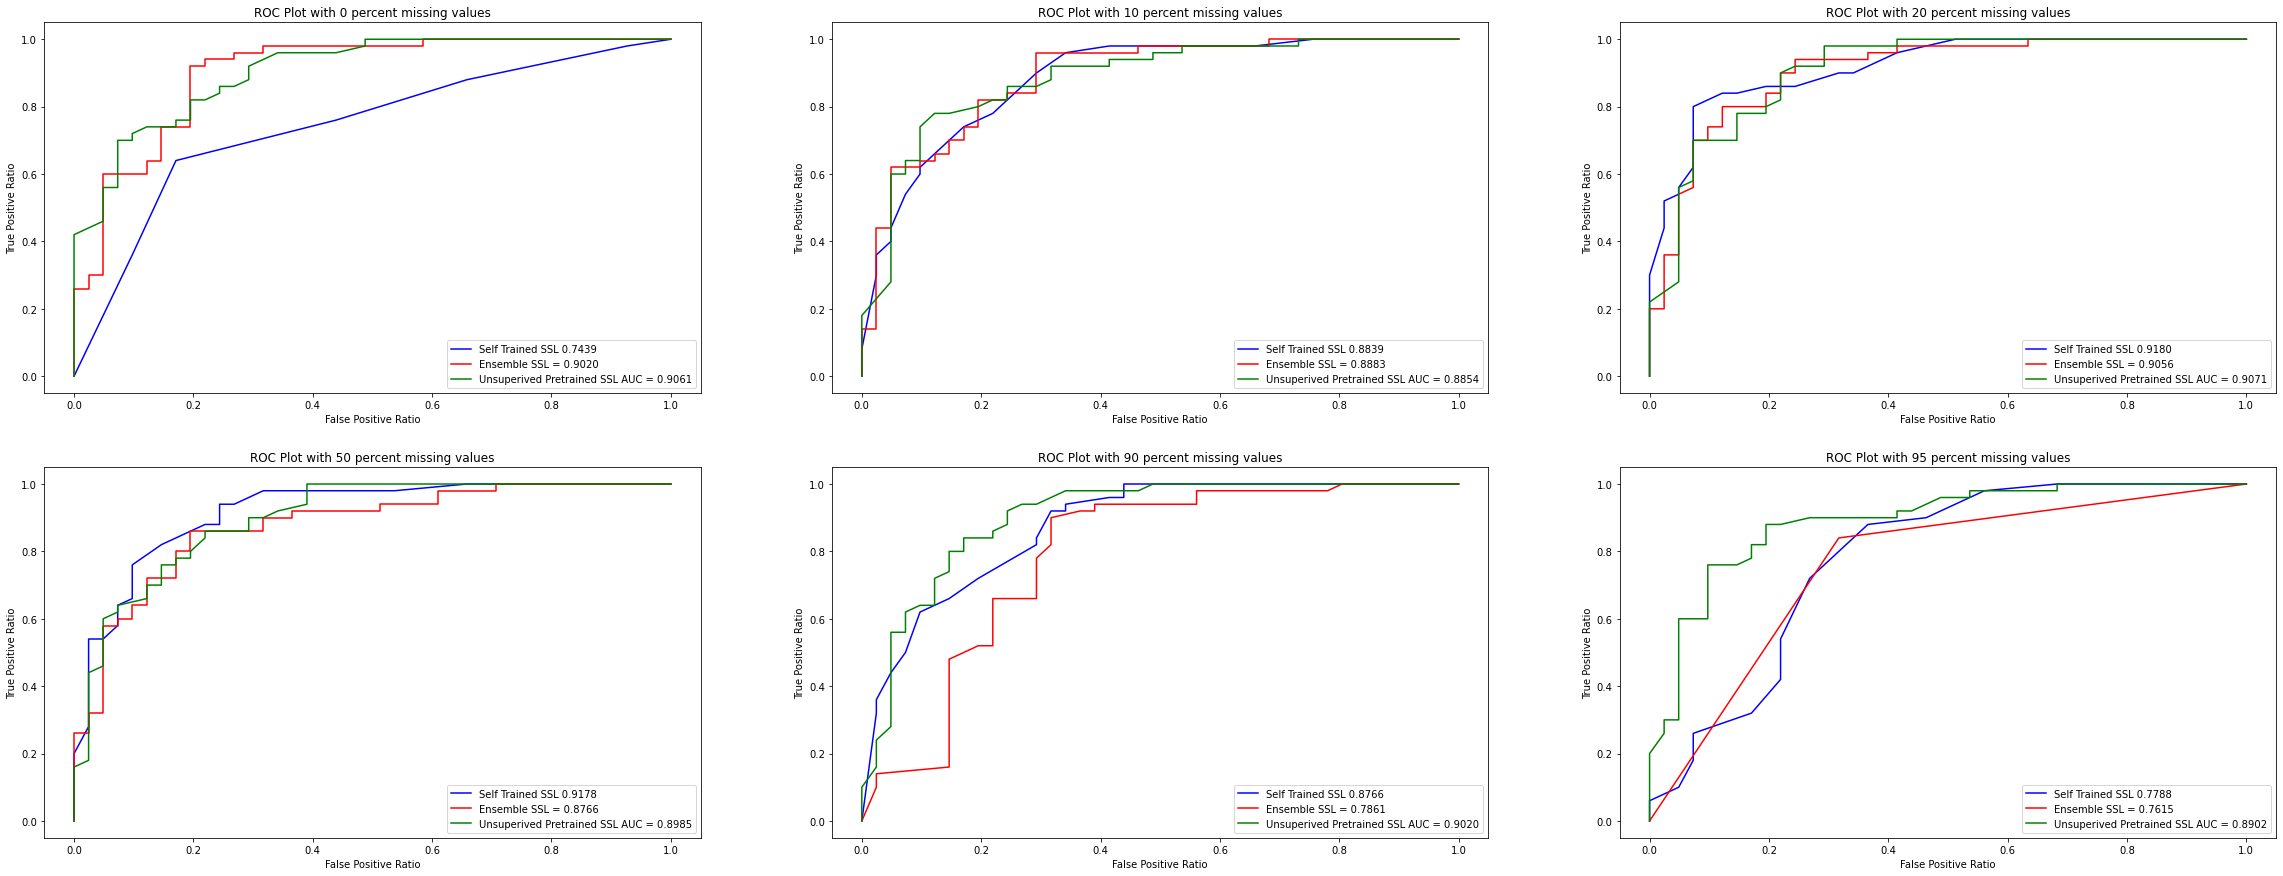

In [276]:
result_df_heart_bal=performance_evaluator_f1(heart_scaled,True,label_ratios)

## Preparing for Statistical Difference Test

In [288]:
with pd.ExcelWriter('Balanced.xlsx') as writer:  
    result_df_shopper_bal.to_excel(writer, sheet_name='Shopper')
    result_df_heart_bal.to_excel(writer, sheet_name='Heart')
    result_df_market_bal.to_excel(writer, sheet_name='Market')

In [278]:
models_list_unbal=[result_df_shopper_unbal.iloc[3:,:],result_df_market_unbal.iloc[3:,:], result_df_heart_unbal.iloc[3:,:]]
models_list_bal=[result_df_shopper_bal.iloc[3:,:],result_df_market_bal.iloc[3:,:], result_df_heart_bal.iloc[3:,:]]

In [279]:
def get_model_results(models):
    final_models=pd.DataFrame()
    for model in models:
        temp=model.iloc[:,:-1].groupby(['Label_ratio','Algorithm']).sum().unstack().fillna(0)
        final_models=pd.concat([final_models,temp])
    return final_models

In [280]:
def Friedman_Neyman_manual_test(model_results):

    rank_data=pd.DataFrame()
    for i in range(len(model_results)):
        rank_data=pd.concat([rank_data,pd.DataFrame(model_results.iloc[i,:].rank(ascending=False,axis=0).to_dict(), index=[i])],axis=0) 
    agg_rank=rank_data.sum(axis=0)
    sum_sq=np.sum(np.square(agg_rank))*(12/(model_results.shape[0]*(model_results.shape[1]+1)*model_results.shape[1]))
    f_statistics=sum_sq-(3*model_results.shape[0]*(model_results.shape[1]+1))
    avg_rank_n=agg_result(rank_data)
    return f_statistics, avg_rank_n

In [281]:
def agg_result(model_result):
    agg_result=pd.DataFrame(model_result.iloc[1:,:].mean().to_dict(),index=[model_result.index.values[-1]])
    return agg_result

## Performing Friedman/Nemenyi test

In [294]:
model_results_unbal=get_model_results(models_list_unbal)
model_results_bal=get_model_results(models_list_bal)

In [295]:
f_stats_unbal, rank_unbal=Friedman_Neyman_manual_test(model_results_unbal)

In [296]:
f_stats_bal, rank_bal=Friedman_Neyman_manual_test(model_results_bal)

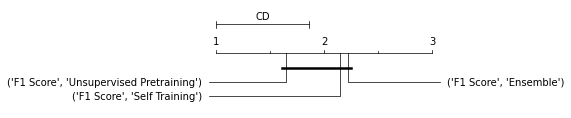

In [297]:
import Orange
names = rank_bal.columns
avranks=list(rank_bal.iloc[0,:])
cd = Orange.evaluation.compute_CD(avranks, 15) #tested on 3 datasets
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
plt.show()

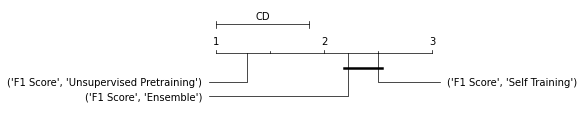

In [298]:
names = rank_unbal.columns
avranks=list(rank_unbal.iloc[0,:])
cd2 = Orange.evaluation.compute_CD(avranks, 15) #tested on 3 datasets
Orange.evaluation.graph_ranks(avranks, names, cd=cd2, width=6, textspace=1.5)
plt.show()

In [299]:
f_stats_unbal

12.933333333333337

In [300]:
f_stats_bal

1.5999999999999943